# Генерация изображений с помощью GAN

In [1]:
from cyclegan.dataset import ImageDataset, denorm
from cyclegan.cycleGAN_model import CycleGAN
from cyclegan.unet_generator import UNetGenerator
from cyclegan.default_generator import DefaultGenerator
from cyclegan.patchgan_discriminator import PatchGANDiscriminator
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image

import torch.nn as nn

In [2]:
img_side = 256

batch_size = 8

n_workers = 4

dataset_path = "./dataset"

In [3]:
def show_images(images, nmax=64, title='Image'):
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    batch = next(iter(dl))
    show_images(batch['A'], nmax, title='Input Images (A)')
    show_images(batch['B'], nmax, title='Monet Images (B)')
        

In [4]:
transform = [
    transforms.Resize(int(img_side * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_side, img_side)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [5]:
train_dataset = ImageDataset(dataset_path, transform, unaligned=True)
test_dataset = ImageDataset(dataset_path, transform, unaligned=True, mode="test")

In [6]:
# Training data loader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_workers,
)
# Test data loader
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
)

torch.Size([3, 256, 256])

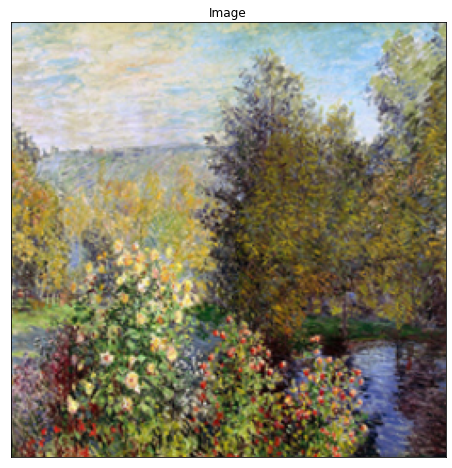

In [7]:
display(train_dataset[0]["A"].shape)
show_images(train_dataset[0]["A"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])


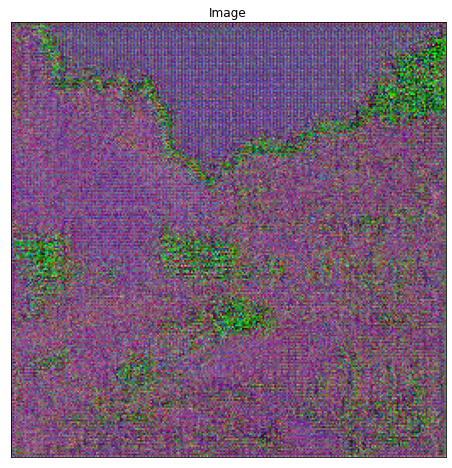

In [8]:
# Создание экземпляра генератора
unet_gen = CycleGAN.create_network('unet')
# Применение генератора к случайному изображению

generated_image = unet_gen(train_dataset[1]["A"].unsqueeze(0))

# Размерность сгенерированного изображения
print(generated_image.shape)
show_images(generated_image)

torch.Size([1, 3, 256, 256])


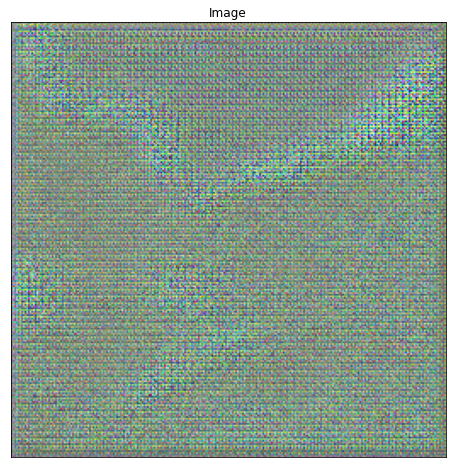

In [9]:
# Создание экземпляра генератора
def_gen = CycleGAN.create_network('default')

# Применение генератора к случайному изображению
generated_image = def_gen(train_dataset[1]["A"].unsqueeze(0))

# Размерность сгенерированного изображения
print(generated_image.shape)
show_images(generated_image)

In [10]:
discriminator = CycleGAN.create_network('discriminator')

# Входной тензор размером 3x70x70
fake_patch = torch.randn((1, 3, 256, 256))
output = discriminator(fake_patch)
print(output.shape)  # Размер выходного тензора


torch.Size([1, 1, 30, 30])


In [11]:
cycleGan = CycleGAN()

In [12]:
print(cycleGan)

CycleGAN Model:
 - Generator A: DefaultGenerator(
  (ds): DownSamplingInput(
    (ds_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (8): ReLU()
    )
  )
  (residual_blocks): Sequential(
    (0): InstanseResidualBlock(
      (res_block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
        (3):

In [13]:
real_A = train_dataset[0]["A"].unsqueeze(0)
real_B = train_dataset[0]["B"].unsqueeze(0)

In [15]:
cycleGan.compute_loss(real_A, real_B)

{'loss_G_A': tensor(1.2438, device='mps:0', grad_fn=<MseLossBackward0>),
 'loss_G_B': tensor(0.8831, device='mps:0', grad_fn=<MseLossBackward0>),
 'loss_cycle_A': tensor(0.5606, device='mps:0', grad_fn=<MeanBackward0>),
 'loss_cycle_B': tensor(0.5915, device='mps:0', grad_fn=<MeanBackward0>),
 'loss_D_A': tensor(0.6832, device='mps:0', grad_fn=<MulBackward0>),
 'loss_D_B': tensor(0.5038, device='mps:0', grad_fn=<MulBackward0>)}

In [21]:
import torch.optim as optim
import itertools

def train_cycle_gan(cycle_gan, train_dataloader, num_epochs=10, lr=0.0002):
    optimizer_G = optim.Adam(itertools.chain(cycle_gan.G_A.parameters(), cycle_gan.G_B.parameters()), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(itertools.chain(cycle_gan.D_A.parameters(), cycle_gan.D_B.parameters()), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, batch in enumerate(train_dataloader):
            real_A = batch['A'].to(cycle_gan.device)
            real_B = batch['B'].to(cycle_gan.device)

            # Обнуляем градиенты перед каждой итерацией обучения
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()

            # Проход через сеть, вычисление потерь
            losses = cycle_gan.compute_loss(real_A, real_B)

            # Обратный проход и обновление параметров для дискриминаторов
            losses['loss_D_A'].backward(retain_graph=True)
            losses['loss_D_B'].backward()
            optimizer_D.step()

            # Обнуление градиентов перед обратным проходом для генераторов
            optimizer_G.zero_grad()

            # Обратный проход и обновление параметров для генераторов
            losses['loss_G_A'].backward()
            losses['loss_G_B'].backward()
            optimizer_G.step()

            # Вывод информации о потерях и прогрессе
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Iteration [{i}/{len(dataloader)}], Losses: {losses}')

        # Сохранение моделей после каждой эпохи (по желанию)
        cycle_gan.save_networks(epoch)

In [22]:
train_cycle_gan(cycleGan, train_dataloader, 3)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
show_batch(train_dataloader)

<center><img src="./unet.jpeg" width="80%"></center>